<a href="https://colab.research.google.com/github/swadhwa12353/JobScrapingADS509/blob/main/ADS_509_Final_Code_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
#Libraries needed
import requests
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#Libraries needed part 2
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
#Libraries need part 3
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix


# Data Scraping with SERP API

In [3]:

SERP_API_KEY = "087c3cfc8cd5162606b894ff06d1ed3b7c34fd4accc7d6e56775ef73dcd6dc41"

# Webscrpaing Function
def fetch_serpapi_jobs_v2(query, location="California", pages=10):
    job_listings = []
    next_token = None

    for i in range(pages):
        print(f"Fetching page {i+1} of {pages} ...")
        params = {
            "engine": "google_jobs",
            "q": query,
            "location": location,
            "api_key": SERP_API_KEY
        }
        if next_token:
            params["next_page_token"] = next_token

        response = requests.get("https://serpapi.com/search", params=params)
        results = response.json()

        jobs = results.get("jobs_results", [])
        if not jobs:
            print(f"No jobs returned on page {i+1}")
            break

        for job in jobs:
            job_listings.append({
                "title": job.get("title"),
                "company": job.get("company_name"),
                "location": job.get("location"),
                "description": job.get("description"),
                "role": query
            })

        next_token = results.get("serpapi_pagination", {}).get("next_page_token")
        if not next_token:
            print("No next_page_token available — stopping early.")
            break

    print(f"Total '{query}' jobs collected: {len(job_listings)}\n")
    return pd.DataFrame(job_listings)

In [4]:
# Fetch up to 200 jobs (10 pages)
df_data_analyst = fetch_serpapi_jobs_v2("data analyst", "California", pages=10)

Fetching page 1 of 10 ...
Fetching page 2 of 10 ...
Fetching page 3 of 10 ...
Fetching page 4 of 10 ...
Fetching page 5 of 10 ...
Fetching page 6 of 10 ...
Fetching page 7 of 10 ...
Fetching page 8 of 10 ...
Fetching page 9 of 10 ...
Fetching page 10 of 10 ...
Total 'data analyst' jobs collected: 91



In [5]:
# Software Engineer job in CA
df_software_engineer = fetch_serpapi_jobs_v2("software engineer", "California", pages=10)

Fetching page 1 of 10 ...
Fetching page 2 of 10 ...
Fetching page 3 of 10 ...
Fetching page 4 of 10 ...
Fetching page 5 of 10 ...
Fetching page 6 of 10 ...
Fetching page 7 of 10 ...
Fetching page 8 of 10 ...
Fetching page 9 of 10 ...
Fetching page 10 of 10 ...
Total 'software engineer' jobs collected: 97



In [6]:
# Accountant job in CA
df_accountant = fetch_serpapi_jobs_v2("accountant", "California", pages=10)

Fetching page 1 of 10 ...
Fetching page 2 of 10 ...
Fetching page 3 of 10 ...
Fetching page 4 of 10 ...
Fetching page 5 of 10 ...
Fetching page 6 of 10 ...
Fetching page 7 of 10 ...
Fetching page 8 of 10 ...
Fetching page 9 of 10 ...
Fetching page 10 of 10 ...
Total 'accountant' jobs collected: 100



In [8]:
# Adding a Role Column for all 3 dataframes
# Organizing the data into 3 different groups
df_software_engineer["role"] = "software engineer"
df_accountant["role"] = "accountant"
df_data_analyst["role"] = "data analyst"

In [10]:
# Combine all datasets
df_combined = pd.concat([df_software_engineer, df_accountant, df_data_analyst], ignore_index=True)

# Cleaning, Normalizing and Tokenizing Data

In [12]:
# Step 1 Cleaning and Normalizing Data
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # remove line breaks
    text = re.sub(r'[^a-zA-Z ]', '', text)  # remove punctuation/numbers
    tokens = text.lower().split() # lowercasing
    tokens = [word for word in tokens if word not in stop_words] #stopword removal
    return ' '.join(tokens)

In [13]:
# Step 1 Cleaning and Normalizing Data
df_combined['clean_description'] = df_combined['description'].apply(clean_text)

In [14]:
# Step 2 Tokenize the cleaned job descriptions
df_combined['tokens'] = df_combined['clean_description'].apply(word_tokenize)

In [15]:
# Step 3 Basic Descriptive Stats
def descriptive_stats(tokens, num_tokens_to_show = 5, verbose=True) :

    if not tokens:
        if verbose:
            print("Token list is empty.")
        return [0, 0, 0.0, 0]

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print(f"\nTop {num_tokens_to_show} most common tokens:")
        for token, count in Counter(tokens).most_common(num_tokens_to_show):
            print(f"{token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

In [16]:
# Step 3 to show descriptive stat
for role, group in df_combined.groupby('role'):
    all_tokens = [token for tokens in group['tokens'] for token in tokens]
    print(f"\n📊 Descriptive Stats for Role: {role.upper()}")
    descriptive_stats(all_tokens, num_tokens_to_show=10)


📊 Descriptive Stats for Role: ACCOUNTANT
There are 36843 tokens in the data.
There are 4702 unique tokens in the data.
There are 279881 characters in the data.
The lexical diversity is 0.128 in the data.

Top 10 most common tokens:
accounting: 684
financial: 499
accountant: 341
experience: 335
work: 254
including: 211
skills: 201
accounts: 179
reporting: 165
required: 158

📊 Descriptive Stats for Role: DATA ANALYST
There are 34710 tokens in the data.
There are 4970 unique tokens in the data.
There are 259778 characters in the data.
The lexical diversity is 0.143 in the data.

Top 10 most common tokens:
data: 996
experience: 363
business: 264
work: 240
analysis: 228
skills: 198
ability: 166
support: 166
analytics: 158
analyst: 157

📊 Descriptive Stats for Role: SOFTWARE ENGINEER
There are 43920 tokens in the data.
There are 5466 unique tokens in the data.
There are 329741 characters in the data.
The lexical diversity is 0.124 in the data.

Top 10 most common tokens:
software: 722
exper

In [17]:
# Downloading the csv file for future use
# No need to rerun the API token again

df_combined.to_csv("combined_job_data_final.csv", index=False)
from google.colab import files
files.download("combined_job_data_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualization

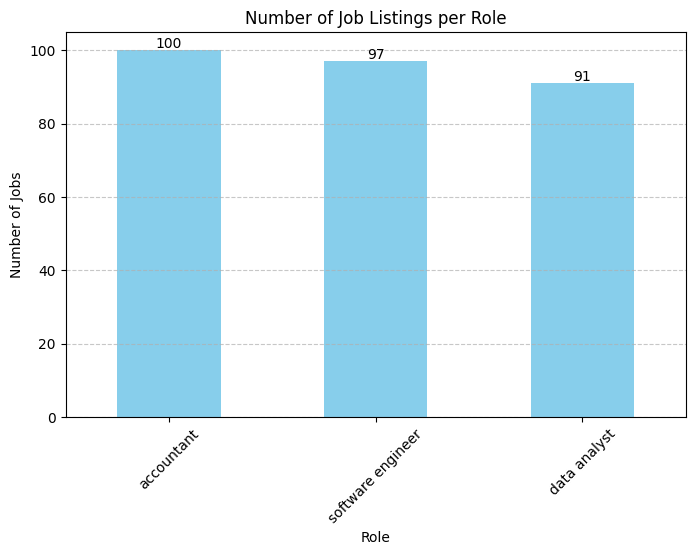

In [21]:
# Bar Chart for JNumber of Jobs per role
role_counts = df_combined['role'].value_counts()

plt.figure(figsize=(8, 5))
ax = role_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Job Listings per Role')
plt.xlabel('Role')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.show()

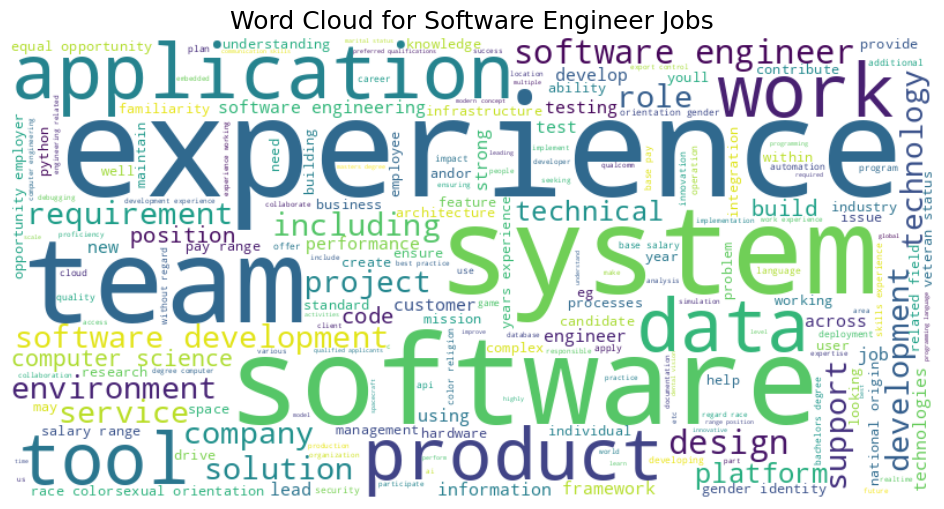

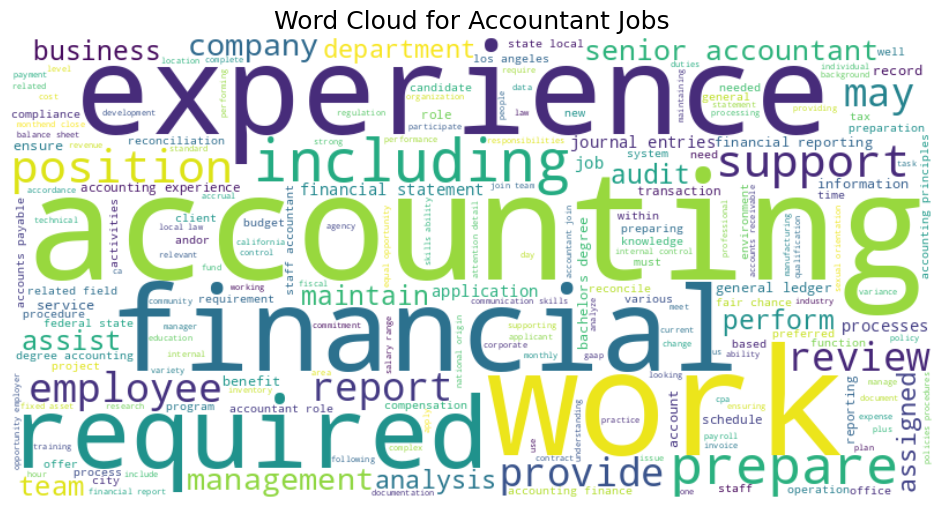

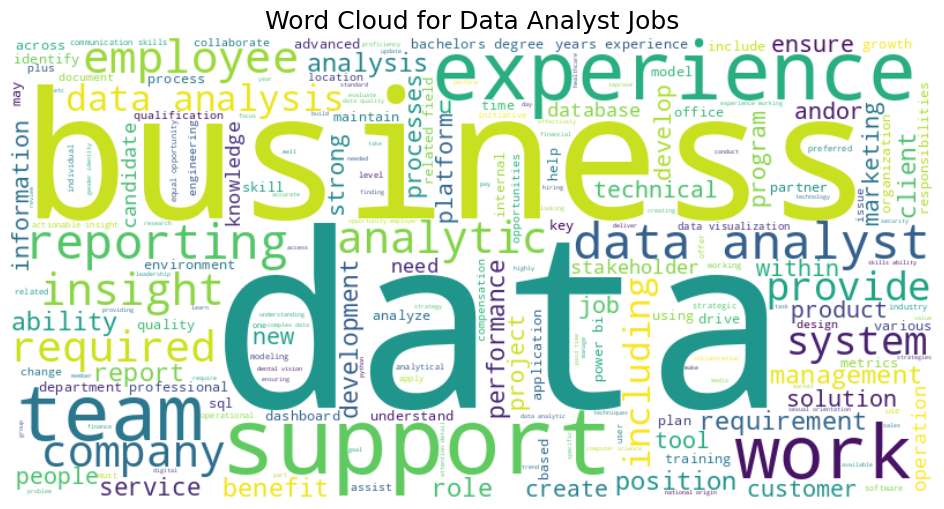

In [25]:
# Wordcloud per Role
for role in df_combined['role'].unique():
    text = ' '.join(df_combined[df_combined['role'] == role]['clean_description'].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {role.title()} Jobs', fontsize=18)
    plt.show()

/tmp/ipython-input-28-2380164544.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


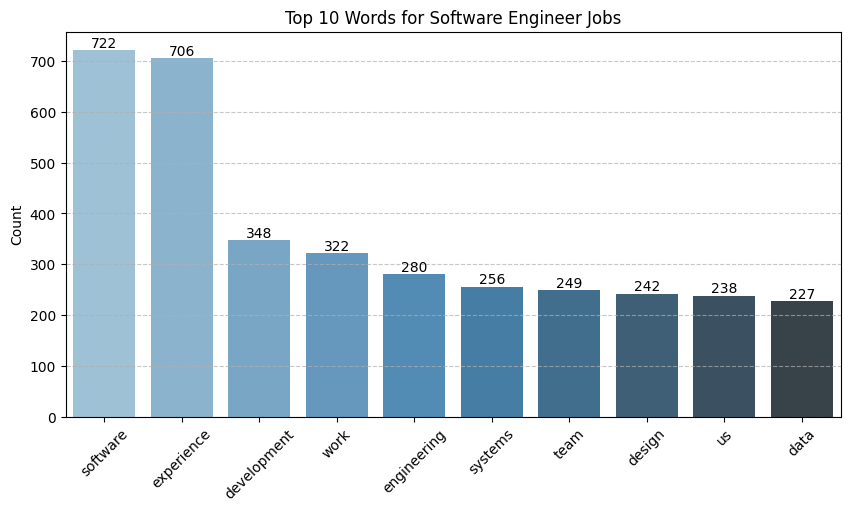

/tmp/ipython-input-28-2380164544.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


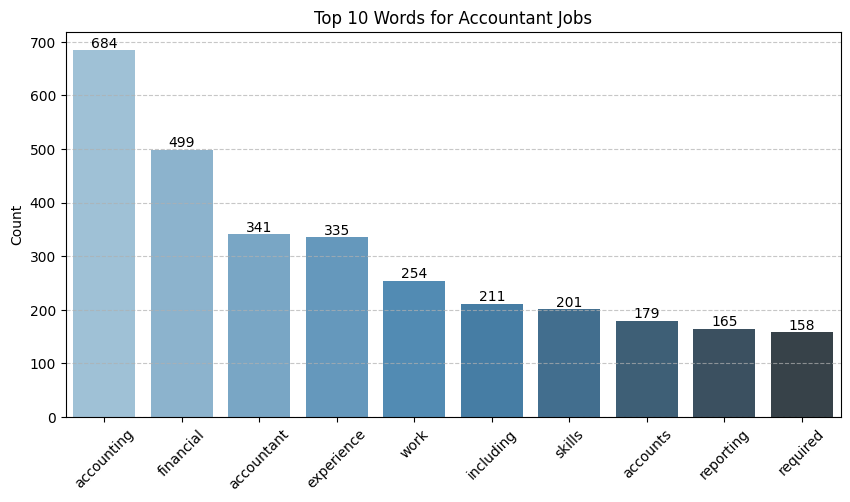

/tmp/ipython-input-28-2380164544.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


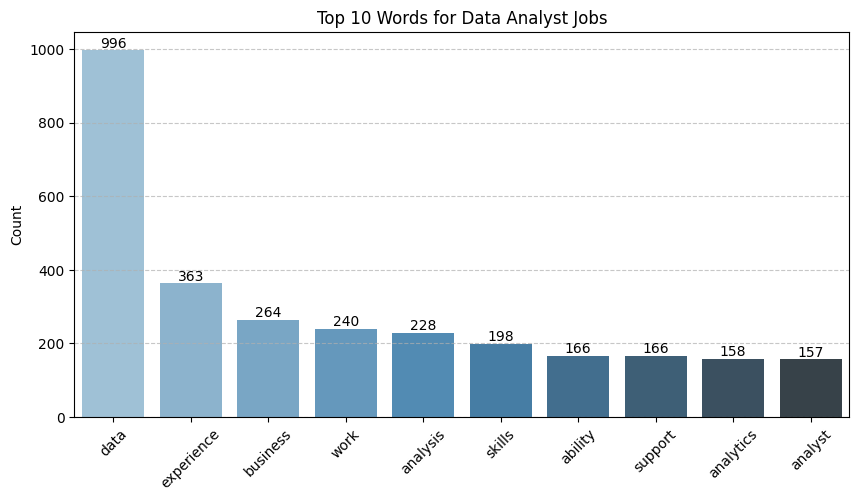

In [28]:
# Top 10 Words per Role
top_n = 10

for role in df_combined['role'].unique():
    all_tokens = [token for tokens in df_combined[df_combined['role'] == role]['tokens'] for token in tokens]
    counter = Counter(all_tokens)
    most_common = counter.most_common(top_n)

    words, counts = zip(*most_common)

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=list(words), y=list(counts), palette='Blues_d')
    plt.title(f'Top {top_n} Words for {role.title()} Jobs')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')

    plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df_combined = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/combined_job_data_final.csv")

In [10]:
# Build X and Define Y

vectorizer = TfidfVectorizer(max_features = 3000)
X = vectorizer.fit_transform(df_combined['clean_description'])
y = df_combined['role']

# Topic Model (LDA)

In [11]:
# Running the Topic Model
lda = LatentDirichletAllocation(n_components = 3, random_state = 42)
fitted = lda.fit_transform(X)

predicted = fitted.argmax(axis = 1)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y)

rand_score = adjusted_rand_score(labels, predicted)
print("\nAdjusted Rand Index (topics vs roles):", rand_score)


Adjusted Rand Index (topics vs roles): -0.0002799946119955746


# Classification Model and Accuracy


In [12]:
# Runing the Classification Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9827586206896551

Classification Report:
                    precision    recall  f1-score   support

       accountant       1.00      1.00      1.00        20
     data analyst       1.00      0.94      0.97        18
software engineer       0.95      1.00      0.98        20

         accuracy                           0.98        58
        macro avg       0.98      0.98      0.98        58
     weighted avg       0.98      0.98      0.98        58



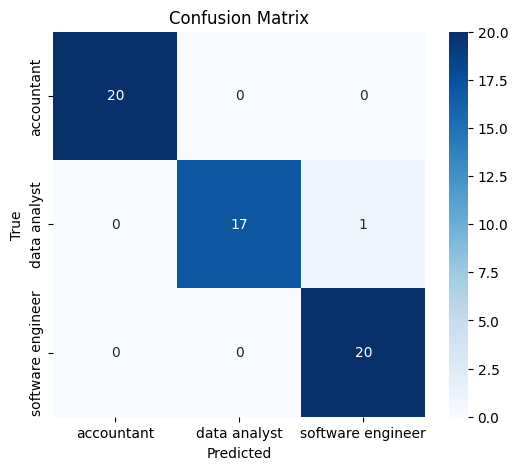

In [15]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()